In [1]:
import urllib.request, json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

from math import atan2,degrees
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import random
from collections import defaultdict

Get Data!

In [8]:
url = 'https://api.rootnet.in/covid19-in/stats/history'
data = pd.read_json(url)
df = json_normalize(data = data['data'], 
                              record_path =['regional'],meta=["day"])


Process Data!

In [9]:
#changes coumns name 'loc' Python call!
df['region']=df['loc']
df=df.drop(columns =["loc"])
df.columns

Index(['confirmedCasesIndian', 'confirmedCasesForeign', 'discharged', 'deaths',
       'totalConfirmed', 'day', 'region'],
      dtype='object')

In [10]:
#reset index as some index missing
df=df.reset_index()

Add 'daily' data from 'totalConfirmed'

In [11]:
#missing sates so, we go one at a time, groups doesn't work!
reg=defaultdict()
for i in range(len(df)): 
    r=df.loc[i].region
    if(r in reg):
        df.loc[i,"daily"] = df.loc[i].totalConfirmed - reg[r]
    else:
        df.loc[i,"daily"] = df.loc[i].totalConfirmed
    reg[r] = df.loc[i].totalConfirmed

In [15]:
#top states only 
states = df.loc[(df['totalConfirmed'] > 500 ) & (df['day'] =='2020-04-18' ) ]['region'].unique()

In [16]:
states

array(['Andhra Pradesh', 'Delhi', 'Gujarat', 'Madhya Pradesh',
       'Maharashtra', 'Rajasthan', 'Tamil Nadu', 'Telengana',
       'Uttar Pradesh'], dtype=object)

In [17]:
#re-arrange 
top = ['Maharashtra', 'Delhi', 'Gujarat', 'Madhya Pradesh',
        'Rajasthan', 'Tamil Nadu', 'Uttar Pradesh','Telengana',
       'Andhra Pradesh', 'Kerala']

In [18]:
#also all India 'daily' plot we need to recalculate
all_df=pd.DataFrame({'daily' : df.groupby( [ "day"] ).sum()['daily']}).reset_index()

In [20]:
#moving average 
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

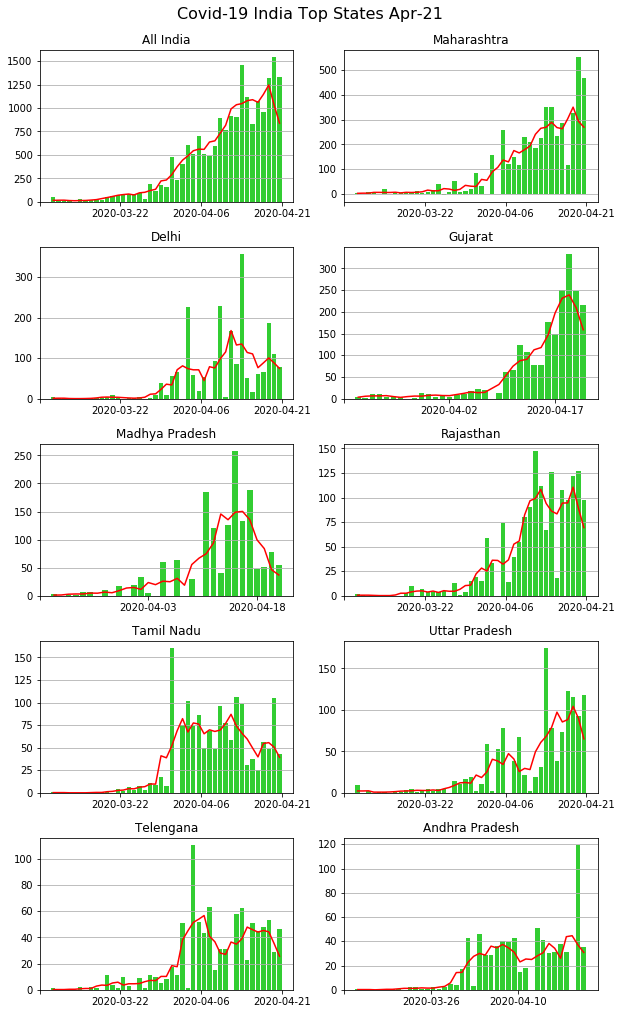

In [21]:
#panel plot 5x2 and first one should be All India!
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15),  
                                             sharex=False, sharey=False)
i=0
for ax in axes.flatten():
    if(i>len(top)-1):
        break
    if(i==0):
        d = all_df
    else:
        d = df[df.region ==top[i-1] ]
    ax.bar(d.day,d.daily, color='#32CD32')
    y_av = movingaverage(d.daily, 5)
    ax.plot(d.day,y_av, 'r')
    startx, endx = ax.get_xlim()
    starty, endy = ax.get_ylim()
    ax.xaxis.set_ticks(np.arange(startx, endx, 15))
    #ax.set_facecolor('#eefff5')
    ax.grid(axis='y')
    #ax.text(endx/2-5, endy/2-2, top[i], fontsize=12)
    if(i==0):
        ax.title.set_text("All India")
    else:
        ax.title.set_text(top[i-1])
    i=i+1
    
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=0.3)
fig.suptitle("Covid-19 India Top States Apr-21",size=16,y=0.92)
#plt.draw()
plt.savefig("covid-top-states-apr22.png",bbox_inches = "tight")
plt.show()